In [359]:
%%capture
! pip install xclim

In [360]:
import xclim.sdba

In [361]:
import xesmf
import xarray as xr
import numpy as np
from science_validation_manual import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sbn
import rhg_compute_tools.kubernetes as rhgk

In [185]:
client, cluster = rhgk.get_micro_cluster()

In [186]:
cluster.scale(100)
cluster

In [187]:
def simple_plot(da, title):
    plt.figure(figsize=(24,24))
    ax = plt.axes(projection=ccrs.PlateCarree())
    da.plot.pcolormesh(ax=ax);
    ax.coastlines();
    plt.title(title)

In [188]:
# Redoing the WDF and regridding manually

In [365]:
# data already WDF (right WDF) from workflow : qdm-preprocess-dev-7qmf9
ds_clean = read_gcs_zarr('gs://clean-b1dbca25/cmip6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/day/pr/gn/v20190318.zarr')
ds_wdf = read_gcs_zarr('gs://scratch-170cd6ec/24fd73ce-f345-4105-a5aa-6c7750359272/qdm-preprocess-dev-7qmf9-3419536200/wdf-corrected.zarr')

In [387]:
# Digging into the weights

In [388]:
# selected two cells from maps : one with pattern, lat lon is [-0.5, -4.5], one without, [-0.5, -3.5]

In [552]:
# get the indices of the respective latitudes and longitudes in the vectors 
latlon_indices = {'pattern':[np.argwhere(domain.lat.values==-0.5).item(), np.argwhere(domain.lon.values==-4.5).item()],
                  'nopattern': [np.argwhere(domain.lat.values==-0.5).item(), np.argwhere(domain.lon.values==-3.5).item()]
                 }

In [508]:
latlon_indices

{'pattern': [89, 175], 'nopattern': [89, 176]}

In [558]:
# element wise product of the latitudes and longitudes indices ('row' values identify an index in that vector in the sparse COO matrix) 
lats = np.arange(1, 181)
lons = np.arange(1, 361)
targetprod = []
for i in lats:
    for j in lons:
        targetprod.append(f'{i},{j}')
targetprod = np.array(targetprod)

In [571]:
# get the indices of the corrseponding latitude/longitude combination
# you should get only one result...
latlon_indice_unique = {'pattern':np.argwhere(targetprod==f"{latlon_indices['pattern'][0]},{latlon_indices['pattern'][1]}").flatten()+1,
                  'nopattern':np.argwhere(targetprod==f"{latlon_indices['nopattern'][0]},{latlon_indices['nopattern'][1]}").flatten()+1}

In [572]:
latlon_indice_unique

{'pattern': array([31855]), 'nopattern': array([31856])}

In [573]:
# get the identifiers in the COO sparse matrix
COO_col_indices = {'pattern':np.argwhere(np.isin(wg['row'].values, latlon_indice_unique['pattern'])).flatten(),
              'nopattern':np.argwhere(np.isin(wg['row'].values, latlon_indice_unique['nopattern'])).flatten()}

In [574]:
COO_col_indices

{'pattern': array([113538, 113539, 113540, 113541]),
 'nopattern': array([113542, 113543])}

In [575]:
COO_weights_row_matches = {'pattern': wg.isel(n_s=COO_col_indices['pattern']),
                           'nopattern': wg.sel(n_s=COO_col_indices['nopattern'])
                          }

In [576]:
COO_weights_row_matches

{'pattern': <xarray.Dataset>
 Dimensions:  (n_s: 4)
 Dimensions without coordinates: n_s
 Data variables:
     S        (n_s) float64 0.8236 0.0549 0.1139 0.007594
     col      (n_s) int32 25276 25277 25596 25597
     row      (n_s) int32 31855 31855 31855 31855,
 'nopattern': <xarray.Dataset>
 Dimensions:  (n_s: 2)
 Dimensions without coordinates: n_s
 Data variables:
     S        (n_s) float64 0.8785 0.1215
     col      (n_s) int32 25277 25597
     row      (n_s) int32 31856 31856}

In [544]:
lats = np.arange(1, 161)
lons = np.arange(1, 321)

In [577]:
sourceprod = []
for i in lats:
    for j in lons:
        sourceprod.append(f'{i},{j}')
sourceprod = np.array(sourceprod)

In [578]:
sourceprod[25277-1]

'71,77'

In [579]:
sourceprod[25597-1]

'72,37'

In [587]:
ds_wdf.lon.values.flatten()[76]

85.5

In [551]:
names[25275-1]

'79,315'

In [465]:
np.unique(wg['col'].values)

array([    1,     2,     3, ..., 51198, 51199, 51200], dtype=int32)

In [464]:
np.argwhere(np.array(list(mydict.values()))==12405)

array([], shape=(0, 1), dtype=int64)

In [414]:
wg['S'].sel(n_s=slice(55258))

<xarray.DataArray 'S' (n_s: 55258)>
array([0.562498, 0.437502, 0.687496, ..., 0.187501, 0.937499, 0.062501])
Dimensions without coordinates: n_s

In [377]:
89*176

15664

In [385]:
np.argwhere(wg['row'].values == 15575)

array([[55258]])

In [396]:
wg

<xarray.Dataset>
Dimensions:  (n_s: 229840)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 0.5625 0.4375 0.6875 0.3125 ... 0.6875 0.4375 0.5625
    col      (n_s) int32 161 162 162 163 163 ... 51039 51039 51040 51040 51041
    row      (n_s) int32 1 1 2 2 3 3 4 ... 64798 64798 64799 64799 64800 64800

In [277]:
cleangrid = xesmf.util.grid_global(1, 1, cf=True)

In [278]:
cleangrid

<xarray.Dataset>
Dimensions:     (bound: 2, lon: 360, lat: 180)
Coordinates:
  * lon         (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bound
Data variables:
    lon_bounds  (bound, lon) int64 -180 -179 -178 -177 -176 ... 177 178 179 180
    lat_bounds  (bound, lat) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89 90

In [282]:
xesmf.util.grid_global(1, 1)

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [266]:
first_time = ds_wdf.isel(time=0).compute()

In [271]:
datavalues = first_time['pr']

In [276]:
lat_bounds_unique = np.unique(first_time.lat_bnds.values)
lon_bounds_unique = np.unique(first_time.lon_bnds.values)

In [ ]:
lat_bounds_unique_da = xr.DataArray(lat_bounds_unique)

In [ ]:
newgrid = xr.Dataset({'lon_bounds':, 'lat_bounds':})

In [279]:
newgrid = cleangrid

In [ ]:
newgrid.lat

In [366]:
# regridding
domain = read_gcs_zarr('gs://support-c23ff1a3/domain.1x1.zarr')
regridder = xesmf.Regridder(ds_in=ds_wdf, ds_out=domain, method='conservative')
regridded = regridder(indata=ds_wdf['pr'])

In [196]:
domain.sel(lat=slice(20, 24), lon=slice(8, 12)).sel(lat_b=slice(20, 24), lon_b=slice(8, 12))

<xarray.Dataset>
Dimensions:  (lat: 4, lat_b: 5, lon: 4, lon_b: 5)
Coordinates:
  * lat      (lat) float64 20.5 21.5 22.5 23.5
  * lat_b    (lat_b) int64 20 21 22 23 24
  * lon      (lon) float64 8.5 9.5 10.5 11.5
  * lon_b    (lon_b) int64 8 9 10 11 12
Data variables:
    *empty*
Attributes:
    history:      created by Diana Gergel, 2021-04-22 02:08:24
    source code:  grid specified by xesmf, xe.util.grid_global(1, 1)
    title:        Rhodium/CIL bias correction and downscaling 1-degree grid

In [198]:
computed = ds_wdf.isel(time=0).compute()

In [205]:
computed.sel(lat=slice(19, 25), lon=slice(7, 13))

<xarray.Dataset>
Dimensions:   (lat: 5, bnds: 2, lon: 5)
Coordinates:
  * lat       (lat) float64 19.63 20.75 21.87 22.99 24.11
    lat_bnds  (lat, bnds) float64 19.07 20.19 20.19 21.31 ... 23.55 23.55 24.67
  * lon       (lon) float64 7.875 9.0 10.12 11.25 12.38
    lon_bnds  (lon, bnds) float64 7.312 8.438 8.438 9.562 ... 11.81 11.81 12.94
    time      object 2004-01-01 12:00:00
Dimensions without coordinates: bnds
Data variables:
    pr        (lat, lon) float64 0.924 0.7607 0.9061 ... 0.9578 0.9618 0.6557
Attributes: (12/54)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           Standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   2015.0
    cmor_version:            3.3.2
    ...                      ...
    table_info:              Creation Date:(30 July 2018) MD5:e53ff52009d0b97...
    title:                   BCC-CSM2-MR output prepared for CMIP6
    tracking_id:             hdl:21.14100/a318dc6d-0cef-4de9-bdc6-839e9c96499...
    variable_id:             pr
    variant_label:           r1i1p1f1
    version_id:              v20190318

In [ ]:
np.diff(computed.lat_bnds.values.flatten())

In [196]:
domain.sel(lat=slice(20, 24), lon=slice(8, 12)).sel(lat_b=slice(20, 24), lon_b=slice(8, 12))

<xarray.Dataset>
Dimensions:  (lat: 4, lat_b: 5, lon: 4, lon_b: 5)
Coordinates:
  * lat      (lat) float64 20.5 21.5 22.5 23.5
  * lat_b    (lat_b) int64 20 21 22 23 24
  * lon      (lon) float64 8.5 9.5 10.5 11.5
  * lon_b    (lon_b) int64 8 9 10 11 12
Data variables:
    *empty*
Attributes:
    history:      created by Diana Gergel, 2021-04-22 02:08:24
    source code:  grid specified by xesmf, xe.util.grid_global(1, 1)
    title:        Rhodium/CIL bias correction and downscaling 1-degree grid

In [156]:
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_160x320_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (160, 320) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

In [155]:
(180*360)

64800

In [363]:
wg = xr.open_dataset('test_weight.nc4')

In [364]:
wg

<xarray.Dataset>
Dimensions:  (n_s: 229840)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

<AxesSubplot:ylabel='Density'>

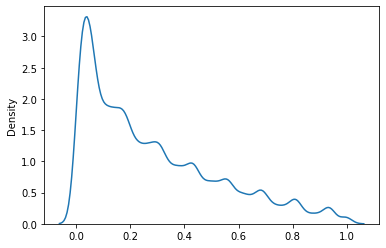

In [285]:
sbn.kdeplot(wg['S'].values)

In [165]:
wg['S'].values[0:60]

array([0.56249844, 0.43750156, 0.68749591, 0.31250409, 0.81249517,
       0.18750483, 0.9374974 , 0.0625026 , 1.        , 0.0625026 ,
       0.9374974 , 0.18750483, 0.81249517, 0.31250409, 0.68749591,
       0.43750156, 0.56249844, 0.56249844, 0.43750156, 0.68749591,
       0.31250409, 0.81249517, 0.18750483, 0.9374974 , 0.0625026 ,
       1.        , 0.0625026 , 0.9374974 , 0.18750483, 0.81249517,
       0.31250409, 0.68749591, 0.43750156, 0.56249844, 0.56249844,
       0.43750156, 0.68749591, 0.31250409, 0.81249517, 0.18750483,
       0.9374974 , 0.0625026 , 1.        , 0.0625026 , 0.9374974 ,
       0.18750483, 0.81249517, 0.31250409, 0.68749591, 0.43750156,
       0.56249844, 0.56249844, 0.43750156, 0.68749591, 0.31250409,
       0.81249517, 0.18750483, 0.9374974 , 0.0625026 , 1.        ])

In [318]:
np.int64(np.unique(wg.row.values))

array([    1,     2,     3, ..., 64798, 64799, 64800])

In [320]:
np.arange(1, 64801)

array([    1,     2,     3, ..., 64798, 64799, 64800])

In [329]:
wg['S'].values[900:950]

array([0.33363123, 0.66636877, 0.02085361, 0.3127799 , 0.04164899,
       0.6247175 , 0.06255955, 0.27107634, 0.12494528, 0.54141883,
       0.1042641 , 0.22937338, 0.20823999, 0.45812253, 0.14596766,
       0.18767062, 0.2915339 , 0.37482782, 0.18767062, 0.14596766,
       0.37482782, 0.2915339 , 0.22937338, 0.1042641 , 0.45812253,
       0.20823999, 0.27107634, 0.06255955, 0.54141883, 0.12494528,
       0.3127799 , 0.02085361, 0.6247175 , 0.04164899, 0.33363123,
       0.66636877, 0.02085361, 0.3127799 , 0.04164899, 0.6247175 ,
       0.06255955, 0.27107634, 0.12494528, 0.54141883, 0.1042641 ,
       0.22937338, 0.20823999, 0.45812253, 0.14596766, 0.18767062])

In [338]:
np.unique(wg['col'].values)

array([    1,     2,     3, ..., 51198, 51199, 51200], dtype=int32)

In [339]:
wg

<xarray.Dataset>
Dimensions:  (n_s: 229840)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 0.5625 0.4375 0.6875 0.3125 ... 0.6875 0.4375 0.5625
    col      (n_s) int32 161 162 162 163 163 ... 51039 51039 51040 51040 51041
    row      (n_s) int32 1 1 2 2 3 3 4 ... 64798 64798 64799 64799 64800 64800

In [346]:
wg['row'].where(wg['row']==1,drop=True)

<xarray.DataArray 'row' (n_s: 2)>
array([1., 1.])
Dimensions without coordinates: n_s

In [340]:
51200*64800

3317760000

In [326]:
domain

<xarray.Dataset>
Dimensions:  (lat: 180, lat_b: 181, lon: 360, lon_b: 361)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lat_b    (lat_b) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lon_b    (lon_b) int64 -180 -179 -178 -177 -176 -175 ... 176 177 178 179 180
Data variables:
    *empty*
Attributes:
    history:      created by Diana Gergel, 2021-04-22 02:08:24
    source code:  grid specified by xesmf, xe.util.grid_global(1, 1)
    title:        Rhodium/CIL bias correction and downscaling 1-degree grid

In [324]:
np.diff(np.argwhere(np.isclose(wg['S'].values,1)).flatten())

array([   17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,  6817,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17, 12257,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17,    17,    17,    17,    17,    17,    17,    17,
          17,    17, 10897,    17,    17,    17,    17,    17,    17,
          17,    17,

In [297]:
wg.col.values[0:50]

array([161, 162, 162, 163, 163, 164, 164, 165, 165, 165, 166, 166, 167,
       167, 168, 168, 169, 169, 170, 170, 171, 171, 172, 172, 173, 173,
       173, 174, 174, 175, 175, 176, 176, 177, 177, 178, 178, 179, 179,
       180, 180, 181, 181, 181, 182, 182, 183, 183, 184, 184], dtype=int32)

In [292]:
wg['S'].where(wg['S']>0.97, drop=True)

<xarray.DataArray 'S' (n_s: 1280)>
array([1., 1., 1., ..., 1., 1., 1.])
Dimensions without coordinates: n_s

In [289]:
domain

<xarray.Dataset>
Dimensions:  (lat: 180, lat_b: 181, lon: 360, lon_b: 361)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lat_b    (lat_b) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lon_b    (lon_b) int64 -180 -179 -178 -177 -176 -175 ... 176 177 178 179 180
Data variables:
    *empty*
Attributes:
    history:      created by Diana Gergel, 2021-04-22 02:08:24
    source code:  grid specified by xesmf, xe.util.grid_global(1, 1)
    title:        Rhodium/CIL bias correction and downscaling 1-degree grid

In [ ]:
xesmf.smm.read_weights('test_weight.nc4', 320, 360)

In [352]:
ds_wdf

<xarray.Dataset>
Dimensions:   (lat: 160, bnds: 2, lon: 320, time: 35405)
Coordinates:
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(160, 2), meta=np.ndarray>
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(320, 2), meta=np.ndarray>
  * time      (time) object 2004-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    pr        (time, lat, lon) float64 dask.array<chunksize=(365, 160, 320), meta=np.ndarray>
Attributes: (12/54)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           Standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   2015.0
    cmor_version:            3.3.2
    ...                      ...
    table_info:              Creation Date:(30 July 2018) MD5:e53ff52009d0b97...
    title:                   BCC-CSM2-MR output prepared for CMIP6
    tracking_id:             hdl:21.14100/a318dc6d-0cef-4de9-bdc6-839e9c96499...
    variable_id:             pr
    variant_label:           r1i1p1f1
    version_id:              v20190318

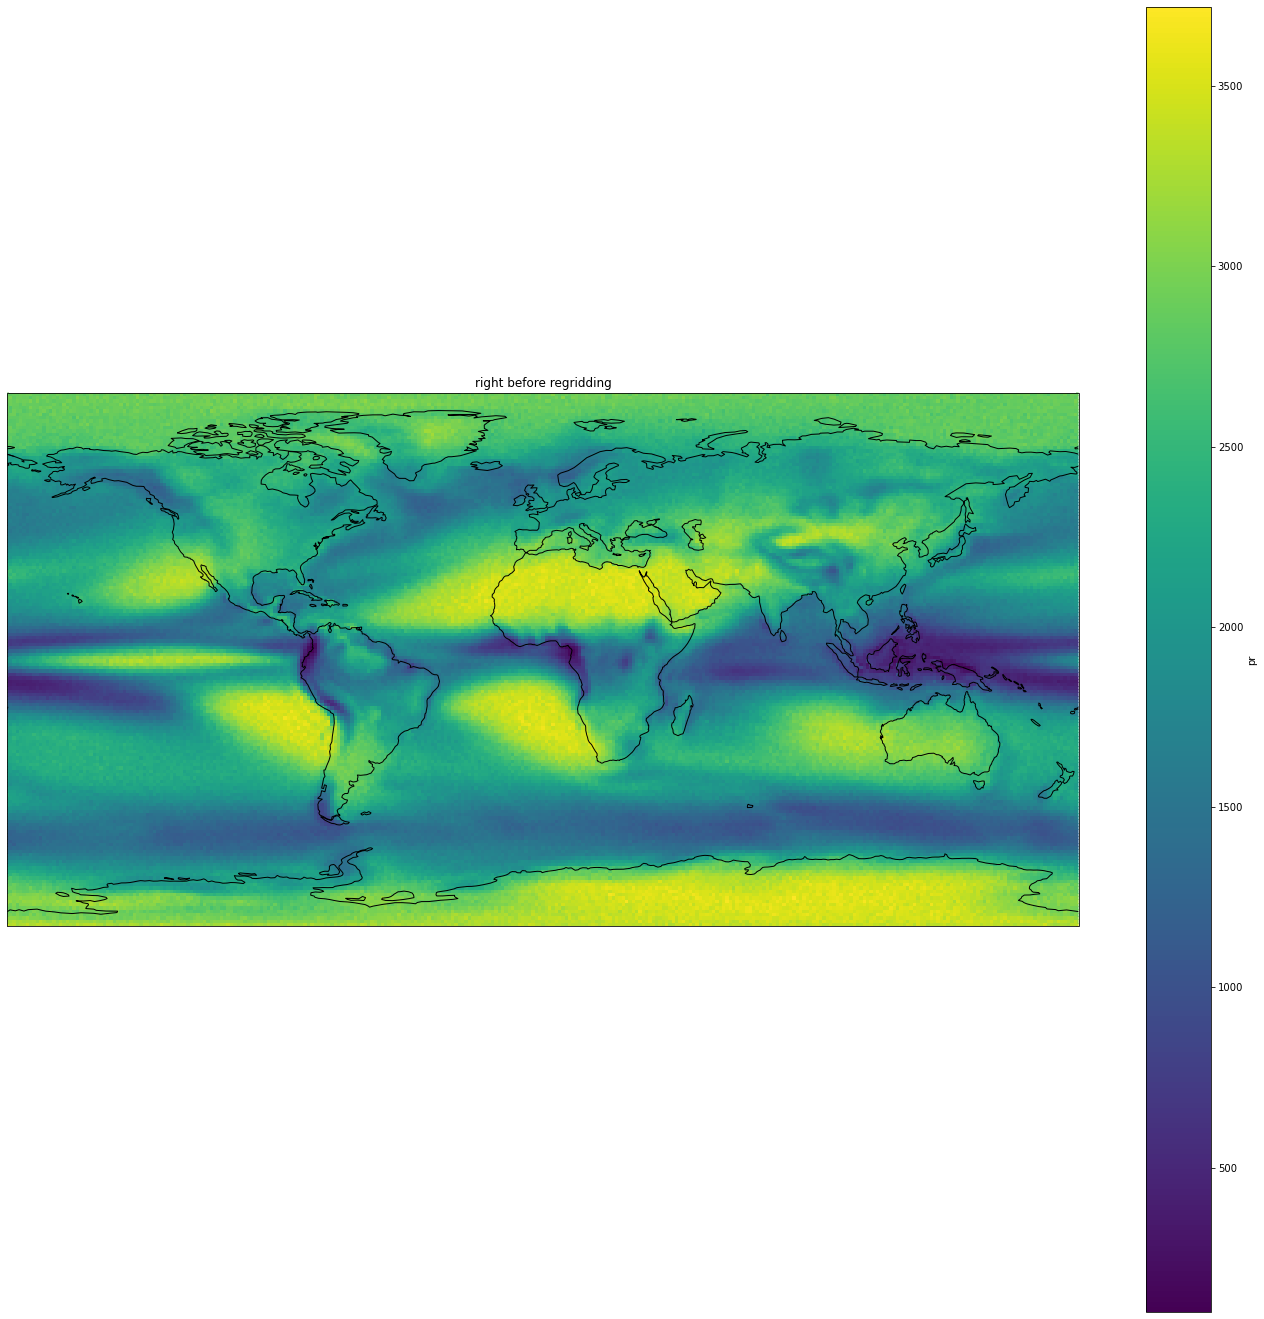

In [356]:
simple_plot(ds_wdf['pr'].where(ds_wdf['pr'] < 0.55).count('time'), 'right before regridding')

In [ ]:
min = regridded.min().compute()

distributed.client - WARNING - Couldn't gather 12 keys, rescheduling {"('_regrid-ee2614b2c3c93402a92a5296706230ed', 53, 0, 0)": ('tls://10.20.131.3:37621',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 4, 0, 0)": ('tls://10.20.143.4:38315',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 10, 0, 0)": ('tls://10.20.138.2:46505',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 55, 0, 0)": ('tls://10.20.141.3:46287',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 36, 0, 0)": ('tls://10.20.141.3:46287', 'tls://10.20.137.2:44975'), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 40, 0, 0)": ('tls://10.20.131.3:37621', 'tls://10.20.137.4:40395'), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 29, 0, 0)": ('tls://10.20.138.5:41447',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 66, 0, 0)": ('tls://10.20.138.3:36537',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 75, 0, 0)": ('tls://10.20.138.8:42815',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 56, 0, 0)": ('tls://10.20.138.7:33831',),

In [ ]:
regridded.where(reridded==min, drop=True)

In [229]:
counts = regridded.where(regridded < 0.51).count('time').compute()

In [238]:
counts.where(counts>600, drop=True).lat.values

array([-89.5, -83.5, -73.5, -36.5, -27.5, -18.5,  -9.5,  -0.5,   0.5,
        18.5,  27.5,  36.5,  46.5,  73.5,  83.5,  89.5])

In [239]:
counts.sel(lon=-4.5, lat=-0.5) # weird cell 

<xarray.DataArray ()>
array(260)
Coordinates:
    lon      float64 -4.5
    lat      float64 -0.5

In [241]:
counts.sel(lon=-3.5, lat=-0.5) # non weird cell

<xarray.DataArray ()>
array(37)
Coordinates:
    lon      float64 -3.5
    lat      float64 -0.5

In [243]:
ts1 = regridded.sel(lon=-3.5, lat=-0.5).compute()
ts2 = regridded.sel(lon=-4.5, lat=-0.5).compute()

distributed.client - WARNING - Couldn't gather 7 keys, rescheduling {"('_regrid-ee2614b2c3c93402a92a5296706230ed', 82, 0, 0)": ('tls://10.20.138.4:37943',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 5, 0, 0)": ('tls://10.20.138.2:46505',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 47, 0, 0)": ('tls://10.20.137.8:34597',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 77, 0, 0)": ('tls://10.20.137.5:39465',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 9, 0, 0)": ('tls://10.20.138.3:36537',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 64, 0, 0)": ('tls://10.20.131.3:37621',), "('_regrid-ee2614b2c3c93402a92a5296706230ed', 87, 0, 0)": ('tls://10.20.140.5:34203',)}


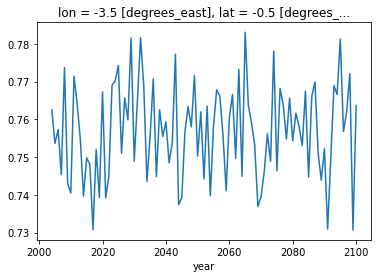

In [256]:
ts1.where(ts1 < 1,drop=True).groupby('time.year').mean().plot()

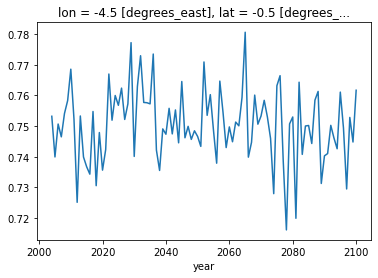

In [255]:
ts2.where(ts2 < 1,drop=True).groupby('time.year').mean().plot()

In [299]:
regridded.min().compute()

<xarray.DataArray ()>
array(0.50000002)

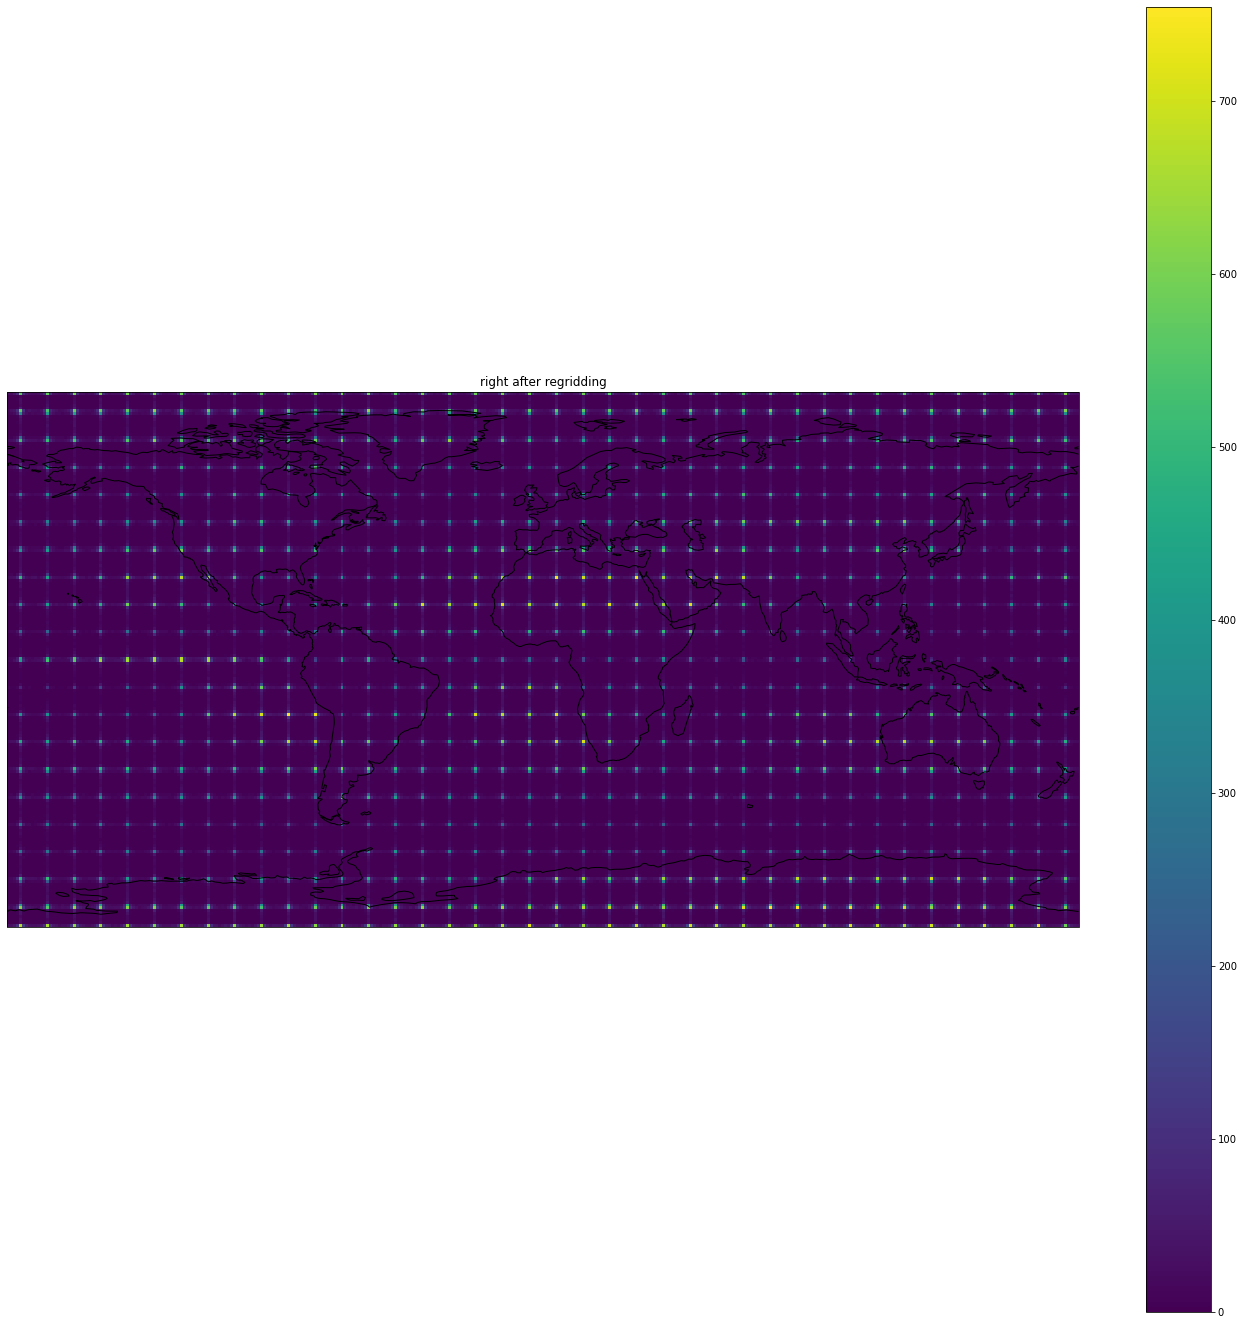

In [357]:
simple_plot(regridded.where(regridded < 0.51).count('time'), 'right after regridding')

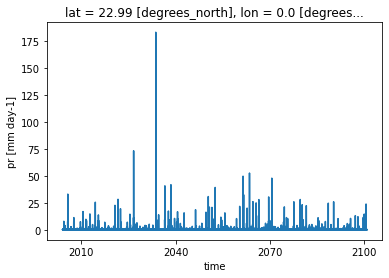

In [78]:
ds_wdf.sel(lat=22.52, lon=-10.04, method='nearest').compute()['pr'].plot()

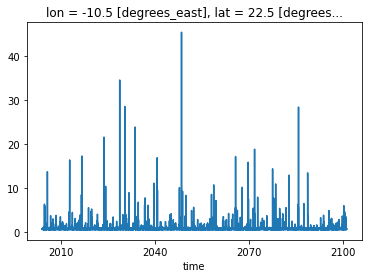

In [79]:
regridded.sel(lat=22.52, lon=-10.04, method='nearest').compute().plot()

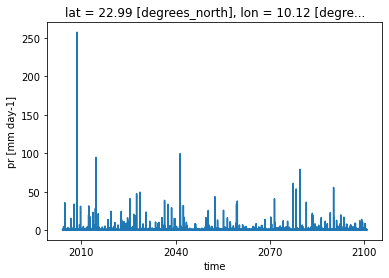

In [80]:
ds_wdf.sel(lat=22.58, lon=9.97, method='nearest').compute()['pr'].plot()

In [218]:
point = ds_wdf.sel(lat=22.58, lon=9.97, method='nearest').compute()['pr']
point.where(point < 1, drop=True)

<xarray.DataArray 'pr' (time: 34580)>
array([0.71118832, 0.60651568, 0.51761011, ..., 0.61423214, 0.93418632,
       0.99782316])
Coordinates:
    lat      float64 22.99
    lon      float64 10.12
  * time     (time) object 2004-01-01 12:00:00 ... 2100-12-31 12:00:00
Attributes:
    units:    mm day-1

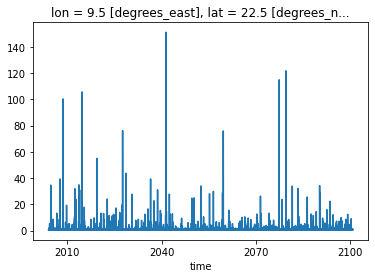

In [81]:
regridded.sel(lat=22.58, lon=9.97, method='nearest').compute().plot()

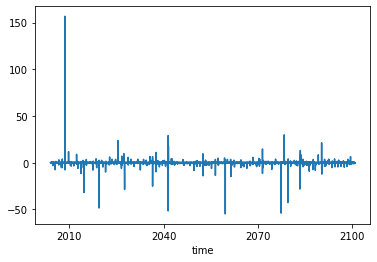

In [92]:
(ds_wdf.sel(lat=22.58, lon=9.97, method='nearest').compute()['pr'] - regridded.sel(lat=22.58, lon=9.97, method='nearest').compute()).plot()

In [99]:
diff = ds_wdf.sel(lat=22.58, lon=9.97, method='nearest').compute()['pr'] - regridded.sel(lat=22.58, lon=9.97, method='nearest').compute()

<AxesSubplot:ylabel='Proportion'>

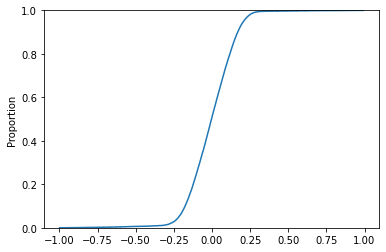

In [102]:
sbn.ecdfplot(diff.where(abs(diff)<1))

In [105]:
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_160x320_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (160, 320) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

In [146]:
ds_clean

<xarray.Dataset>
Dimensions:   (lat: 160, bnds: 2, lon: 320, time: 35405)
Coordinates:
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(160, 2), meta=np.ndarray>
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(320, 2), meta=np.ndarray>
  * time      (time) object 2004-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    pr        (time, lat, lon) float64 dask.array<chunksize=(365, 160, 320), meta=np.ndarray>
Attributes: (12/54)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           Standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   2015.0
    cmor_version:            3.3.2
    ...                      ...
    table_info:              Creation Date:(30 July 2018) MD5:e53ff52009d0b97...
    title:                   BCC-CSM2-MR output prepared for CMIP6
    tracking_id:             hdl:21.14100/a318dc6d-0cef-4de9-bdc6-839e9c96499...
    variable_id:             pr
    variant_label:           r1i1p1f1
    version_id:              v20190318